# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models_v2

import tools as t
import models_v2 as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import time

In [3]:
df_data = t.from_pkl(f'{processed_data_path}/df_clean.pkl')

df_data.shape
df_data.head(3)

(97449, 9)

,make,model,year,price,transmission,mileage,fuelType,tax,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,1.4


In [4]:
df_fiesta = df_data.loc[ 
    (df_data['make'] == 'Ford') & \
    (df_data['model'] == 'Fiesta') & \
    (df_data['transmission'] == 'Manual') & \
    (df_data['fuelType'] == 'Petrol')
].drop(columns=['make', 'model', 'transmission', 'fuelType', 'tax']).copy()

df_fiesta['mileage_5k'] = ((df_fiesta['mileage'] / 5000).round(0)*5000 ).astype(int)
df_fiesta.drop(columns='mileage', inplace=True)
df_fiesta = df_fiesta.loc[df_fiesta['mileage_5k'] <= 80000]

df_fiesta.head(3)
df_fiesta.shape

,year,price,engineSize,mileage_5k
21193,2019,17500,1.5,10000
21195,2015,10500,1.6,35000
21197,2017,9000,1.2,15000


(5615, 4)

In [5]:
def mad(s):
    return (s - s.mean() ).abs().mean()

In [6]:
d = df_fiesta.groupby(['year', 'engineSize', 'mileage_5k'])['price'].agg([len, np.mean, np.std, mad])

'std', d['std'].mean()
'mad', d['mad'].mean()

d.tail(20).style.format('{:.0f}') 

('std', 689.2890039189402)

('mad', 377.10758493341115)

# Encode

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [8]:
## transmission & fuelType

# df_enc1 = df_fiesta_mp.copy()

# df_enc1['transmission'].value_counts()
# df_enc1['fuelType'].value_counts()

# t.ordinalEncode(df_enc1, ['transmission', 'fuelType'])

# df_enc1['transmission'].value_counts()
# df_enc1['fuelType'].value_counts()

## Prep X y

In [9]:
df_train = df_fiesta

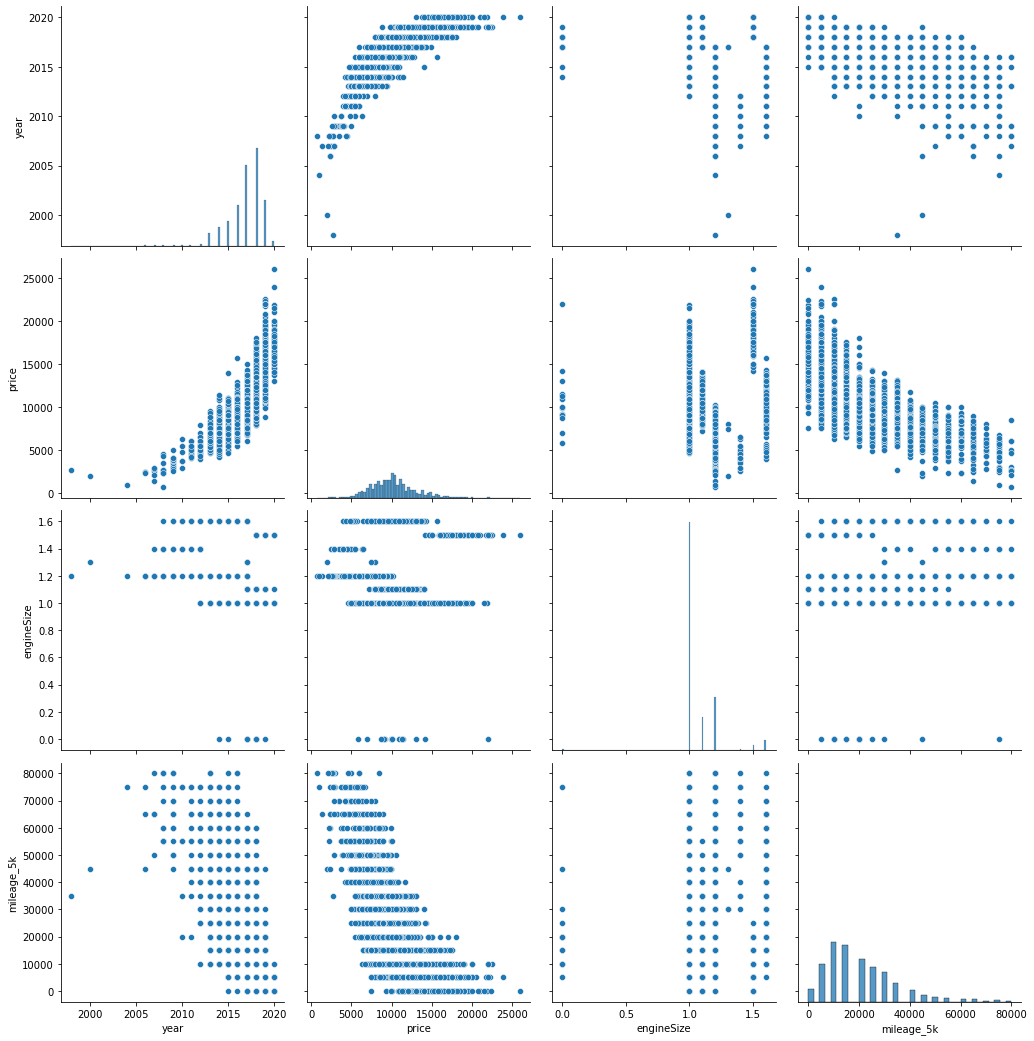

In [10]:
_ = sns.pairplot(data= df_train).fig.set_size_inches(15,15)

In [11]:
df_train.head(3)
df_train.dtypes

,year,price,engineSize,mileage_5k
21193,2019,17500,1.5,10000
21195,2015,10500,1.6,35000
21197,2017,9000,1.2,15000


year            int64
price           int64
engineSize    float64
mileage_5k      int64
dtype: object

In [12]:
X = df_train.drop('price', axis=1)
y = df_train['price']

X.shape
y.shape

(5615, 3)

(5615,)

# Train model

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC

from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

In [14]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2

def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [15]:
all_results = []

In [16]:
n_est_list = [200]
models_and_params = [
    (LinearRegression, {}),
    (Lasso, {'random_state': RS}),
    # (Ridge, {'random_state': RS}),
    (DecisionTreeRegressor, {}),
    # *[ (RandomForestRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
    # *[ (AdaBoostRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in  n_est_list],
    *[ (LGBMRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
]
cv = KFold(5)
metrics = [ mae, rmse, r2]

r = t.grid_exec(
    lambda model: m.cv_regression(model, cv, X, y, metrics), 
    models_and_params, 
    on1Completed = lambda r: m.display_stats(r)
)


,model,params,n_folds,MAE_mean,MAE_std,rmse_mean,rmse_std,R2_mean,R2_std,time
0,LinearRegression,,5,1224,62,1633,133,0.625,0.034,0.0
1,Lasso,,5,1224,62,1633,134,0.625,0.034,0.1
2,DecisionTreeRegressor,,5,755,47,1018,70,0.854,0.010,0.1
3,LGBMRegressor,'n_estimators': 200,5,752,48,1013,72,0.856,0.010,33.8


In [17]:
from sklearn.preprocessing import PolynomialFeatures
n_est_list = [300]
models_and_params = [
    (LinearRegression, {}),
    # (Lasso, {'random_state': RS}),
    # (Ridge, {'random_state': RS}),
]
cv = RepeatedKFold(n_splits=5, n_repeats=2)
metrics = [ r2]

res = []
for i in range(15):
    X_p = pd.DataFrame(data=PolynomialFeatures(degree=i).fit_transform(X))
    r = t.grid_exec(
        lambda model: m.cv_regression(model, cv, X_p, y, metrics), 
        models_and_params, 
        on1Completed = lambda r: m.display_stats(r)
    )
    res.extend(r)
    m.display_stats(res)

,model,params,n_folds,R2_mean,R2_std,time
0,LinearRegression,,10,-0.00,0.00,0.1
1,LinearRegression,,10,0.67,0.01,0.1
2,LinearRegression,,10,0.75,0.02,0.3
3,LinearRegression,,10,0.80,0.07,0.1
4,LinearRegression,,10,0.72,0.17,0.3
5,LinearRegression,,10,0.75,0.03,0.4
6,LinearRegression,,10,0.73,0.05,0.7
7,LinearRegression,,10,0.72,0.05,0.9
8,LinearRegression,,10,0.64,0.16,0.5
9,LinearRegression,,10,0.04,0.55,0.9
